# Final Exam (Part 2) - EEG analysis 

### For this part of the final exam we will make use of the techniques we learned in filtering of EEG time series and FFT analysis of amplitude in different frequencies to develop single-trial classifiers.  

### The first set of problems are focused on P300 detection and identification on single trials. We will make use of the data file, '2_P3.mat'

## README 

### The information about the datafiles in an experiment is normally placed in a README file. 
### For convenience I am going to place that information here instead.

###  This data was obtained from the archive ERP CORE and reorganized for this class. 
###  Each file contains the data of one participant, indicated in the filename. 
###  The variables contained here are 

*   `ntrials` - number of trials in the experiment 
*   `nchannels` - number of EEG channels 
*   `samplingrate` - number of samples of EEG in per second
*   `eeg` - eegdata of the experiment.  of dimensions, ntrials x nchannels x ntimepoints.  The EEG is provided in units of volts. 
*   `eeg_time` - the time relative to *stimulus onset* in each EEG observation.
*   `channelnames` - the name of the EEG channels indicating where it is located.    
*   `stimulus` - the stimulus presented on each good trial, 1 = A, 2 = B, 3 = C, 4 = D, 5 = E 
*   `target` - the target stimulus on each good trial 1 = A, 2 = B, 3 = C, 4 = D, 5 = E
*   `blocktarget` - indicates which trial had the target on each block, 1 if a target 0 if not a target. 
*   `response` - variable indicating the response accuracy 1 = correct, -1 = incorrect, 0 = no response,
*   `responsetime` - time after stimulus onset when the subject provided a response. 
*   `goodtrials` - vector with value 1 if the trial had a response, 0 if no response or multiple responses.  

In [2]:
from hdf5storage import loadmat
import numpy as np 
from matplotlib import pyplot as plt 
from eeg import makefilter
from scipy import signal

In [4]:
data = loadmat('final/2_P3.mat')
blocktarget = data['blocktarget']
channelnames = data['channelnames']
eeg = data['eeg']
eeg_time = data['eeg_time']
goodtrials = data['goodtrials']
nchannels = data['nchannels']
ntrials = data['ntrials']
response = data['response']
responsetime = data['responsetime']
samplingrate = data['samplingrate']
stimulus = data['stimulus']
target = data['target']
eeg = eeg*10**6

#### 1. Make a filter and low-pass filter the entire EEG data to only keep EEG signals below fp = 3.5, with a hard stop at fs = 6. Make a plot of the filtered data (all trials) at channel Pz drawing the targets and standards in different colors. (Hint: Your plot will be much easier to see if you plot the standards first) 

In [5]:
fp = 3.5
fs = 6
b,a,w,h = makefilter(samplingrate,fp,fs) # the parameters b and a contain the filter information. 
eegfilt = signal.filtfilt(b,a,eeg,axis=2) # The orignal data is trial x chan x time.  hence i filter over axis = 2 

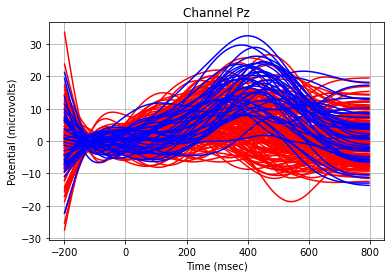

In [6]:
plt.plot(eeg_time,np.transpose(eegfilt[blocktarget == 0,12,:]),'r')
plt.plot(eeg_time,np.transpose(eegfilt[blocktarget > 0,12,:]),'b')
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.ylabel('Potential (microvolts)')
plt.grid()
plt.show()

#### 2. At each time point, use LDA to classify the EEG as standard or target. On the same graph, Make a plot of the fraction of targets detected versus time (hits), and the fraction of standard falsely labeled as targets (false alarms).  

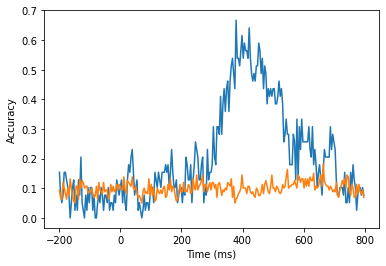

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold 
kf = KFold(n_splits = 5,shuffle = True)
falsealarms = np.zeros(256)
hits = np.zeros(256)
for k in range(256):

    z_T = np.squeeze(eeg[:,:,k]) 
    errors = 0
    predictions = np.zeros(np.shape(z_T)[0])
    probability = np.zeros((len(predictions),2))
    clabel = np.zeros(len(blocktarget))
    clabel[blocktarget > 0] = 1
    for train_index, test_index in kf.split(z_T):
        #    print("TRAIN:", train_index, "TEST:", test_index)
        data_train = z_T[train_index]
        data_test = z_T[test_index]
        Label_train= clabel[train_index] 
        Label_test = clabel[test_index]
        clf = LDA(n_components =1)
        #clf = svm.SVC()
        data_model = clf.fit(data_train, Label_train)
        predict = clf.predict(data_test)
        test = Label_test == predict
        errors = errors + sum(~test)
        predictions[test_index] = predict
        #    probability[test_index,:] = clf.predict_proba(data_test)
        errorrate = errors/len(clabel)
        #plt.plot(np.arange(0,50,1),accuracy_f,'r')
    hits[k] = np.sum(predictions[blocktarget > 0] == clabel[blocktarget > 0])/np.sum(blocktarget > 0)
    falsealarms[k] = np.sum(predictions[blocktarget == 0] == 1)/np.sum(blocktarget == 0)
plt.plot(eeg_time,hits)
plt.plot(eeg_time,falsealarms)
plt.xlabel('Time (ms)')
plt.ylabel('Accuracy')
plt.show()

### The second part of this exam involves using spectral analysis to estimate how individuals are deploying covert attention.  This has applications both in cognitive neuroscience experiments (to assess how a participant is deploying attention) and in Brain-Computer Interfaces.  

### The data set provided in the file covertattention.mat is from an experiment where the subject is asked to deploy attention to one of 6 angular positions in a circle (30,90,150,210,270,330) and discriminate a briefly flashed stimulus at that location.  Deploying attention is necessary to perform the task accurately, and we will analyze the interval between the cue and target onset, when attention is deployed.  

#### The data file ia called covertattention.mat. The following code will load the file and extract the variables of interest.  

In [9]:
x = loadmat('covertattention.mat')
x.keys()

dict_keys(['angle', 'angle_labels', 'channels', 'eeg', 'idx2000', 'sr'])

In [40]:
angle = x['angle'][0] # index to the angle of attentional deployment. 
angle_labels = x['angle_labels'][0] # the 6 angles used in the experiment
y = x['channels'][0] #EEG channel names
channelnames = list() # some cleaning up
for j in range(62):
    channelnames.append(y[j][0])
eeg = x['eeg'] #eeg data 
ntrials = np.shape(eeg)[0]
nchannels = np.shape(eeg)[1]
samplingrate = x['sr'] #sampling rate 

###  The variables contained here are 

*   `ntrials` - number of trials in the experiment 
*   `nchannels` - number of EEG channels 
*   `samplingrate` - number of samples of EEG in per second
*   `eeg` - eegdata of the experiment.  of dimensions, ntrials x nchannels x ntimepoints.  The EEG is provided in units of volts. 
*   `channelnames` - the name of the EEG channels indicating where it is located.    
*   `angle` - a numerical index to the angle to which attention is directed by a cue at the start of the trial, 0 = 30, 2 = 90, 3 = 150, 4 = 210, 5 = 270, 6 = 330
*   `angle_labels` - the angle in degrees corresponding to each index.   

#### 3. Use the FFT to compute the amplitude spectrum of each channel on each trial using the 1 second prior to the onset of the target (samples 300 to 500) 

In [14]:
from scipy.fftpack import fft
poststim = range(300,500,1)
nsamp = len(poststim)
T = len(poststim)/samplingrate  # T should be 0.5 s
deltaf = 1/T # deltaf should be 2
fft_eeg = fft(eeg[:,:,poststim],axis = 2)
amplitude = 2*np.abs(fft_eeg)/nsamp/deltaf

#### 4. Use LDA to classify the angle at which attention is deployed at each frequency from 0 to 30 Hz.  Only use the channels over occipital (O1, Oz, O2) and parietal/occipital (PO3-PO10) indicated in this list. 
#### `channels = list([16,24,54,55,56,57,58,59,60,61])`
#### Make a plot of classification performance in 5-fold cross validation versus frequency. Indicate chance performance by a horizontal dashed line.   

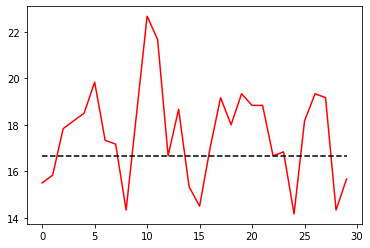

In [37]:
channels = list([16,24,54,55,56,57,58,59,60,61])
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import svm
accuracy_f = np.zeros(30)
for k in range(0,30):
    z_T = np.squeeze(amplitude[:,:,k])
    z_T = z_T[:,channels]
    #z_T = zscore(z_T,axis = 1)
    from sklearn.model_selection import KFold 
    kf = KFold(n_splits = 5,shuffle = True)
    errors = 0
    predictions = np.zeros(np.shape(z_T)[0])
    probability = np.zeros((len(predictions),6))
    clabel = angle
    for train_index, test_index in kf.split(z_T):
        #    print("TRAIN:", train_index, "TEST:", test_index)
        data_train = z_T[train_index]
        data_test = z_T[test_index]
        Label_train= clabel[train_index] 
        Label_test = clabel[test_index]
        clf = LDA(n_components =1)
        #clf = svm.SVC()
        data_model = clf.fit(data_train, Label_train)
        predict = clf.predict(data_test)
        test = Label_test == predict
        errors = errors + sum(~test)
        predictions[test_index] = predict
        #    probability[test_index,:] = clf.predict_proba(data_test)
        errorrate = errors/len(clabel)
        accuracy_f[k] = 100*(1-errorrate)

plt.plot(np.arange(0,30,1),accuracy_f,'r')
plt.plot(np.arange(0,30,1),(100/6)*np.ones(30),'k--')
plt.show()